In [92]:
!pip install pmdarima

In [93]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [94]:
df = pd.read_csv(
    r"C:\Users\avina\OneDrive\Desktop\RP\nep-index.csv",
    index_col = "Date",
    parse_dates = ["Date"],
)
df

,Index
Date,
2014-02-02,775.92
2014-02-03,769.51
2014-02-04,774.91
2014-02-05,781.38
2014-02-06,785.78
...,...
2022-01-09,2765.47
2022-01-10,2784.95
2022-01-11,2834.13


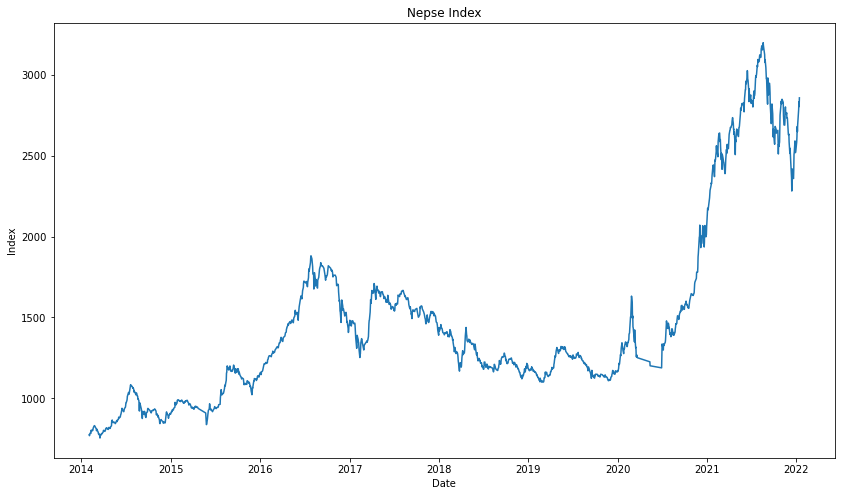

In [95]:
# plot close price
plt.figure(figsize = (14, 8))
#plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Index")
plt.plot(df["Index"])
plt.title("Nepse Index")
plt.show()

<AxesSubplot:ylabel='Density'>

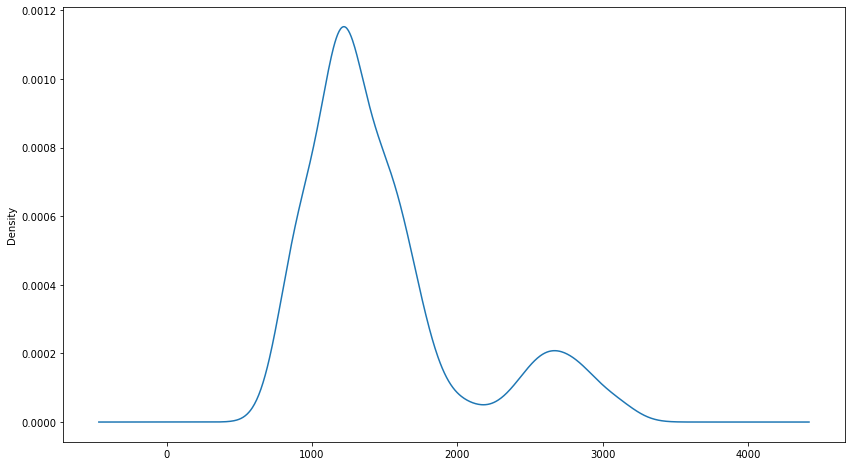

In [96]:
# Distribution of the dataset
df_index = df["Index"]
df_index.plot(kind = "kde")

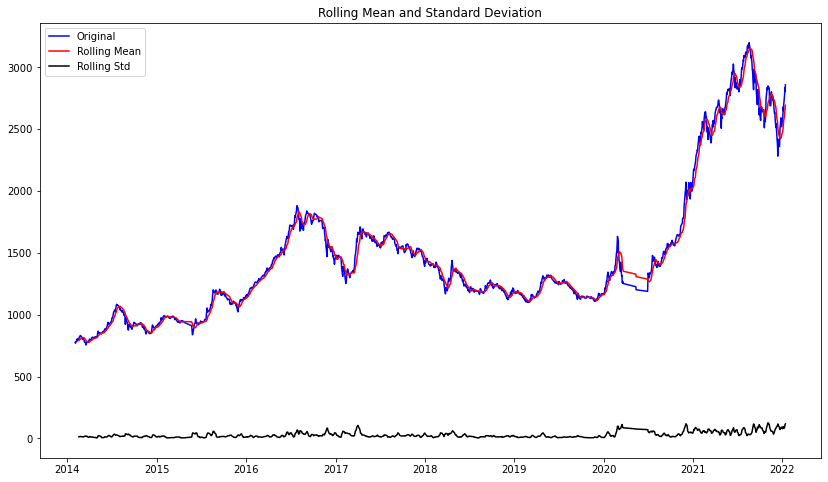

Results of dickey fuller test
Test Statistics                   0.085856
p-value                           0.965082
No. of lags used                 19.000000
Number of observations used    1778.000000
critical value (1%)              -3.434033
critical value (5%)              -2.863167
critical value (10%)             -2.567636
dtype: float64


In [97]:
# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    plt.figure(figsize = (14, 8))
    plt.plot(timeseries, color = "blue", label = "Original")
    plt.plot(rolmean, color = "red", label = "Rolling Mean")
    plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries, autolag="AIC")
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop

    output = pd.Series(
        adft[0:4],
        index = [
            "Test Statistics",
            "p-value",
            "No. of lags used",
            "Number of observations used",
        ],
    )
    for key, values in adft[4].items():
        output["critical value (%s)" % key] = values
    print(output)


test_stationarity(df_index)

<Figure size 1008x576 with 0 Axes>

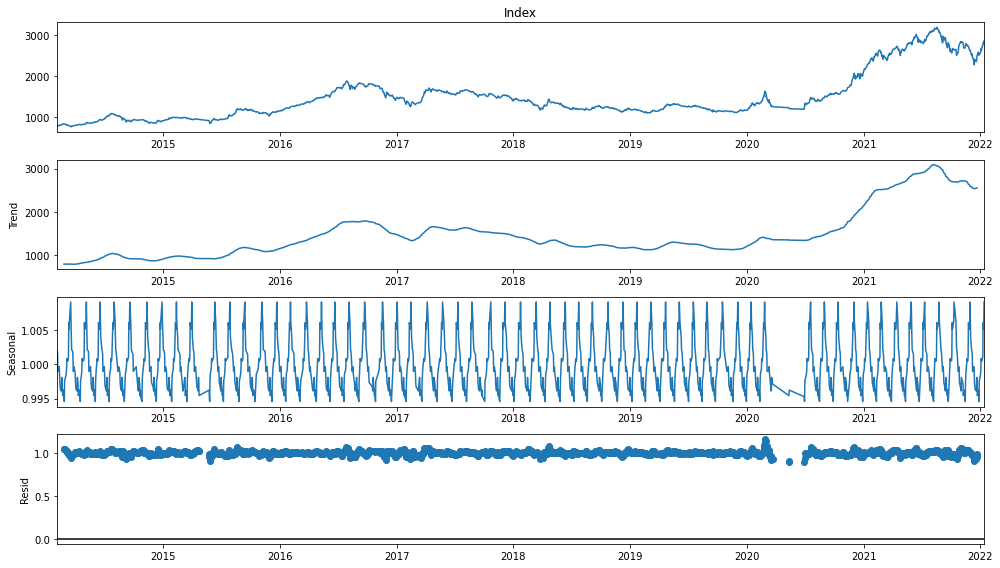

In [98]:
# To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.

result = seasonal_decompose(df_index, model="multiplicative", freq = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 8)

No handles with labels found to put in legend.


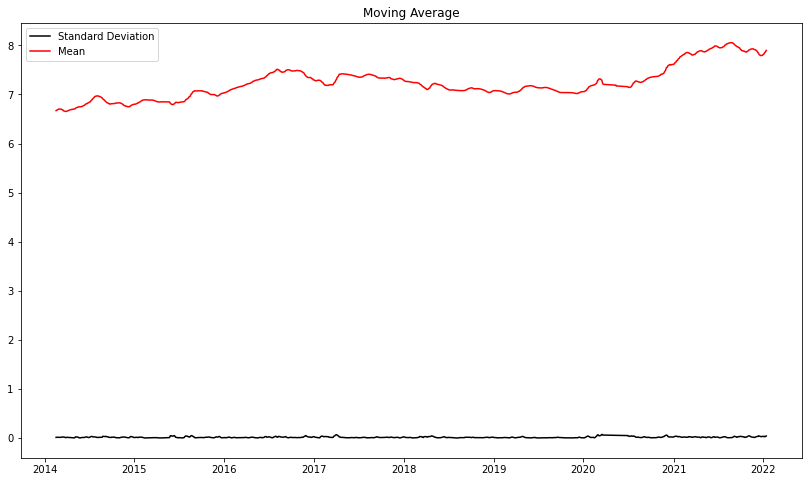

In [99]:
# if not stationary then eliminate trend
# Eliminate trend

from pylab import rcParams

rcParams["figure.figsize"] = 14, 8
df_log = np.log(df_index)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

plt.legend(loc = "best")
plt.title("Moving Average")
plt.plot(std_dev, color = "black", label = "Standard Deviation")
plt.plot(moving_avg, color = "red", label = "Mean")
plt.legend()
plt.show()

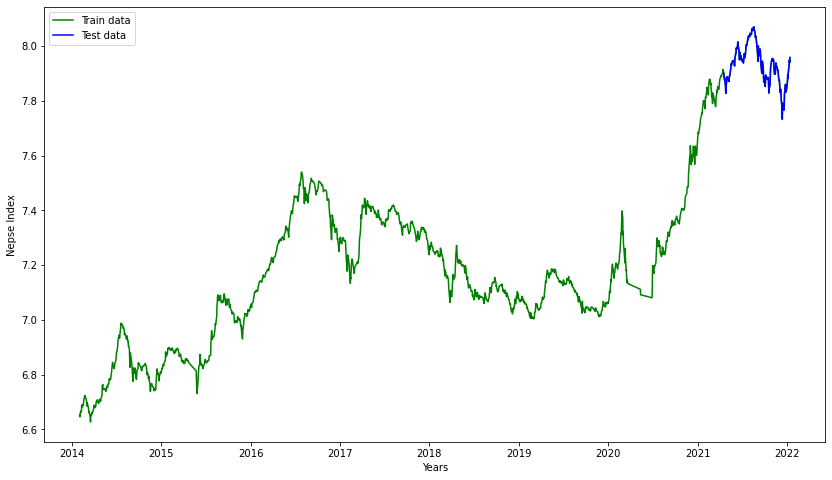

In [100]:
# split data into train and training set

train_data, test_data = (
    df_log[3: int(len(df_log) * 0.9)],
    df_log[int(len(df_log) * 0.9) :],
)
plt.figure(figsize=(14, 8))
#plt.grid(True)
plt.xlabel("Years")
plt.ylabel("Nepse Index")
plt.plot(df_log, "green", label = "Train data")
plt.plot(test_data, "blue", label = "Test data")
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9563.437, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9608.863, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9610.389, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9559.213, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9608.370, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9608.415, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9607.305, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9607.745, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.692 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1615
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4808.194
Date:                Mon, 17 Jan 2022   AIC                          -9610.389
Time:                       

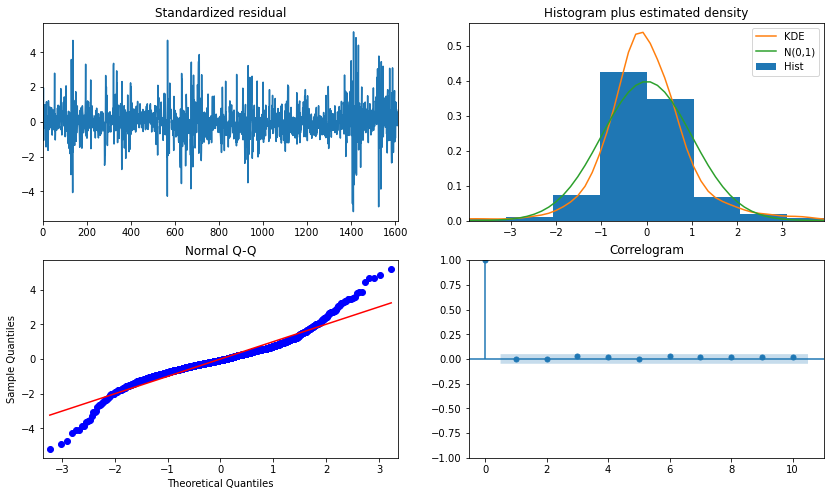

In [101]:
model_autoARIMA = auto_arima(
    train_data,
    start_p = 0,
    start_q = 0,
    test = "adf",  # use adftest to find optimal 'd'
    max_p = 3,
    max_q = 3,  # maximum p and q
    m = 1,  # frequency of series
    d = None,  # let model determine 'd'
    seasonal = False,  # No Seasonality
    start_P = 0,
    D = 0,
    trace = True,
    error_action = "ignore",
    suppress_warnings = True,
    stepwise = True,
)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(14, 8))
plt.show()

In [102]:
# Modeling
# Build Model
model = ARIMA(train_data, order=(0, 1, 1))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Index   No. Observations:                 1614
Model:                 ARIMA(0, 1, 1)   Log Likelihood                4808.195
Method:                       css-mle   S.D. of innovations              0.012
Date:                Mon, 17 Jan 2022   AIC                          -9610.390
Time:                        19:41:46   BIC                          -9594.231
Sample:                             1   HQIC                         -9604.392
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.159      0.031    7.16e-05       0.001
ma.L1.D.Index     0.1765      0.025      7.130      0.000       0.128       0.225
                                    Root

In [103]:
# Forecast
fc, se, conf = fitted.forecast(180, alpha=0.05)  # 95% con

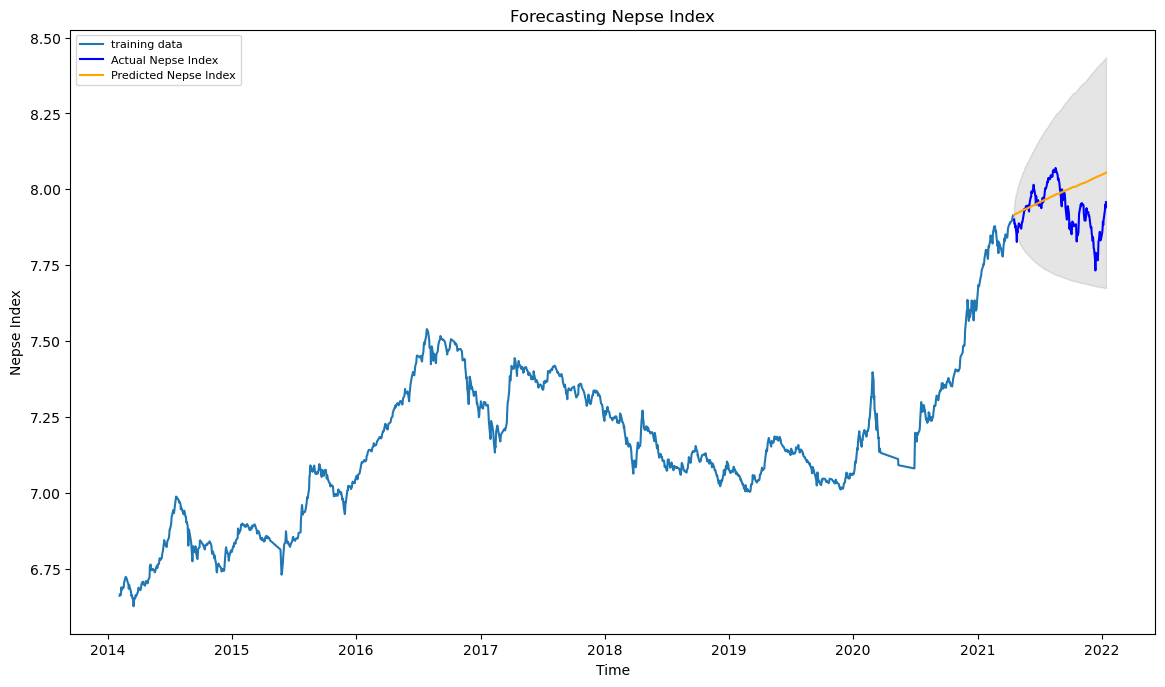

In [104]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(14, 8), dpi=100)
plt.plot(train_data, label="training data")
plt.plot(test_data, color="blue", label="Actual Nepse Index")
plt.plot(fc_series, color="orange", label="Predicted Nepse Index")
plt.fill_between(lower_series.index, lower_series, upper_series, color="k", alpha=0.10)
plt.title("Forecasting Nepse Index")
plt.xlabel("Time")
plt.ylabel("Nepse Index")
plt.legend(loc="upper left", fontsize=8)
plt.show()

In [105]:
# report performance

mse = mean_squared_error(test_data, fc)
print('MSE: '+ str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+ str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+ str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+ str(mape))

MSE: 0.011568610948811502
MAE: 0.08190843473354056
RMSE: 0.10755747741933845
MAPE: 0.010382474954984188
